# Práctica 4 BSS  Entrega NPL

## Objetivos


El objetivo de esta práctica es aplicar los conocimientos obtenidos sobre el procesamiento del lenguaje natural y crear un programa Python, que haciendo uso de alguno de los dataset dispuestos por el profesor realice alguna función.



En mi caso hago uso del dataset de cyberbulling, un dataset compuesto de mensajes de twiter EN INGLÉS, del cual através de la herramientas expuestas en el trabajo, se desarrollara un clasificador con el que podemos agrupar estos tweets.

Posteriormente se mostrarán las palabras más utilizadas y representativas de cada categoria de cyberbulling.

** NOTA **

Me hubiese gustado hacer una ampliación y utilizar este dataset para obtener un porcentaje de mensajes de tipo cyberbulling, de la cuenta de twitter de algún usuario del dataset, pero no soy capaz de que tweepy me devuelva los tweets reales de los usuarios. No se si por que los usuarios del dataset son falsos por que tweety solo es para cuentas en español o por que estoy metiendoo la pata. (lo más seguro)

 



## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. 


* Este fichero lo podemos leer como un '*csv*' con pandas 


* Este fichero esta estructurado de la siguiente manera
    - **tweet text**: Tweet publicado
    - **cyberbullying_type**: Tipo de mensaje no ciberbully o categoria especifica de ciberbully 
  
    
    
* Leemos los datos 

In [1]:
import pandas as pd
import numpy as np

tweets_file = './Entrega 4/NLP_datasets/'
#df = pd.read_csv(tweets_file, sep="", names=['tweet_text','cyberbullying_type'] ,engine='python')
df = pd.read_csv("./cyberbullying.csv")
#df = df[df['sentimiento'].isin(['positivo', 'neutro', 'negativo'])]
#tweets = [tuple(x) for x in df.values]
#print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))


df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


* Tweets publicados por cada categoria.

In [2]:
df_count = df.groupby('cyberbullying_type')['tweet_text'].count().reset_index().sort_values(by='tweet_text', ascending=False)

df_count

,cyberbullying_type,tweet_text
5,religion,7998
0,age,7992
2,gender,7973
1,ethnicity,7961
3,not_cyberbullying,7945
4,other_cyberbullying,7823


* Para esta PoC vamos a utilizar solo el '***Tweet_text***' y la categoria '***cyberbullying_type***' asociado al tweet.

In [3]:
tweets = [list(x) for x in df[['tweet_text', 'cyberbullying_type']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 47692


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un PoC didáctica se ha realizado una normalización '*sencilla*'.


#### CUIDADO - IMPORTANTE:

* Dado que los procesos de normalización de textos son muy pesados y tardan mucho, se ha implementado despues de la normalización de los tweets, un proceso de guardado de los tweets ya normalizados. Por tanto:
    - Si es la primera vez que se ejecuta este notebook, se puede ejecutar completo sabiendo que se guardarán en un fichero binario los tweets normalizados. Este guardado se realiza [AQUI](#Escritura).
    - En caso de haberse ejecutado el proceso de normalización de tweets y haberse guardado este en un fichero binario, no será necesario ejecutar las dos siguientes celdas de código y bastaría con ejecutar la celda de código que lee el fichero binario con los tweets normalizados. Esto se hace en la siguiente [CELDA](#Lectura).

In [4]:
import spacy

from tqdm import tqdm
import en_core_web_sm

nlp = spacy.load("en_core_web_sm")

def normalize(tweets, min_words=5):
    """
    Función que dada una lista de tweets ([tweet, clase]), normaliza los tweets y devuelve una lista
    con los tweets normalizados, descartando aquellos tweets que tras la normalización tengan menos de
    "min_words" palabras en el tweet.
    
    :param tweets:       Lista de Tweets ([tweet, clase]) con el tweet y la clase a la que pertenece
    :param min_words:    Número minimo de palabras que tiene que tener un tweet tras la normalización
    :return:             Lista de Tweets ([tweet, clase]) normalizados
    """
    tweets_list = []
    for tweet in tqdm(tweets):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        tw = nlp(tweet[0].lower().replace('.', ' ').replace('#', ' ').strip())
        
        # Normalizamos Puntos 4,5,6,7 y 8
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (len(word.text) > 2) and (not word.is_stop)
               and (not word.text.startswith('@'))
               and (not word.text.startswith('http'))
               and (not ':' in word.text)])
        
        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            tweets_list.append([" ".join(tw), tweet[1]])
    return tweets_list

# Normalizamos las frases
X_norm = normalize(tweets)
print('Tweets procesados: {}'.format(len(X_norm)))

100%|████████████████████████████████████| 47692/47692 [07:23<00:00, 107.46it/s]

Tweets procesados: 40363


#### <a name="Escritura">Guardado de los tweets normalizados en un fichero binario</a>

* Se guarda una lista de listas, donde en cada una de las listas se tiene:
    - [0]: El Tweet normalizado
    - [1]: La categoria a la que pertenece el Tweet

In [12]:
import pickle

filename = './models/tweets_normalizados.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm, save_list)
save_list.close()

#### <a name="Lectura">Lectura de los tweets normalizados de un fichero binario</a>

* Lectura de una lista con la siguiente estructura:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [13]:
filename = './models/tweets_normalizados.pickle'
X_norm = pickle.load(open(filename, 'rb'))

<hr>


## Bolsa de palabras

* Pasamos a construir una bolsa de palabras de frecuencias.


* Vamos a utilizar (para construir la bolsa de palabras) la clase "*CountVectorizer*" de scikit, quedandonos con:
    - Las 1500 palabras más frecuentes.
    - Que las palabras aparezcan por los menos en 5 tweets.
    (Reduzco el volumen de datos ahora pero se puede cambiar en cualquier momento)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in X_norm]
y = np.array([doc[1] for doc in X_norm])

# Particionamos los datos en Entrenamiento y Test
vectorizer = CountVectorizer(max_features=1500, min_df=5)
vectorizer.fit_transform(X)

# Pasamos los tweets normalizados a Bolsa de palabras
X_bow = vectorizer.transform(X)

<hr>


## Particionado de Datos (Train y Test)



* Seleccionaremos como tweets de entrenamiento.


* Seleccionaremos un 2% de tweets de test, siendo estos los últimos tweets registrados en el dataset (los tweets están escritos de manera cronológica).


* Por tanto nos vamos a quedar con:
    - 98% de datos de entrenamiento
    - 2% de datos de test

In [15]:
PCT_TEST = 0.02
n_tail = X_bow.shape[0] - int(X_bow.shape[0] * PCT_TEST)
print('Corte en el tweet número {} de los {} tweets del Dataset.'.format(n_tail, X_bow.shape[0]))

X_train = X_bow[:n_tail]
y_train = y[:n_tail]
X_test = X_bow[n_tail:]
y_test = y[n_tail:]

print('Tweets de entrenamiento: {}'.format(X_train.shape[0]))
print('Tweets de Test: {}'.format(X_test.shape[0]))

Corte en el tweet número 39556 de los 40363 tweets del Dataset.
Tweets de entrenamiento: 39556
Tweets de Test: 807


<hr>


## Creacción de Modelos y Evaluación (Accuracy)


* Vamos a crear y evaluar una serie de modelos para ver cual es que obtiene mejores resultados.


* Los modelos que vamos a crear y evaluar son los siguientes:
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - Regresion Logistica
    - Support Vector Machine
    - Random Forest
    

* Para simplificar el problema solo vamos a evaluar los modelos (***Cross Validation***) con el accuracy y nos quedaremos con el modelo que mejor accuracy tenga.

In [16]:
import warnings
warnings.filterwarnings("ignore")
import statistics

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_lin = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM Kernel rbf': svm_rbf,
                  'Random Forest d_50': rf_50}

# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento y test
accuracy = list()
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    model = {}
    model['name'] = k
    # Entrenamiento
    v.fit(X_train, y_train)
    
    # Predicción de Entrenamiento y Test
    y_train_pred = v.predict(X_train)
    y_test_pred = v.predict(X_test)
    
    # Cálculo del Accuracy
    model['acc_train'] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    model['acc_test'] = accuracy_score(y_true=y_test, y_pred=y_test_pred)
    
    accuracy.append(model)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: Regresion Logistica
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM Kernel rbf
CREANDO MODELO: Random Forest d_50


In [17]:
# Pasamos los resultados a un DataFrame para visualizarlos mejor
results = pd.DataFrame.from_dict(accuracy)
results.set_index("name", inplace=True)
results[['acc_train', 'acc_test']]

,acc_train,acc_test
name,,
Multinomial NB,0.818485,0.908302
Bernoulli NB,0.851426,0.905824
Regresion Logistica,0.896324,0.938042
SVM lineal,0.906993,0.940520
SVM Kernel rbf,0.906563,0.936803
Random Forest d_50,0.902745,0.923172


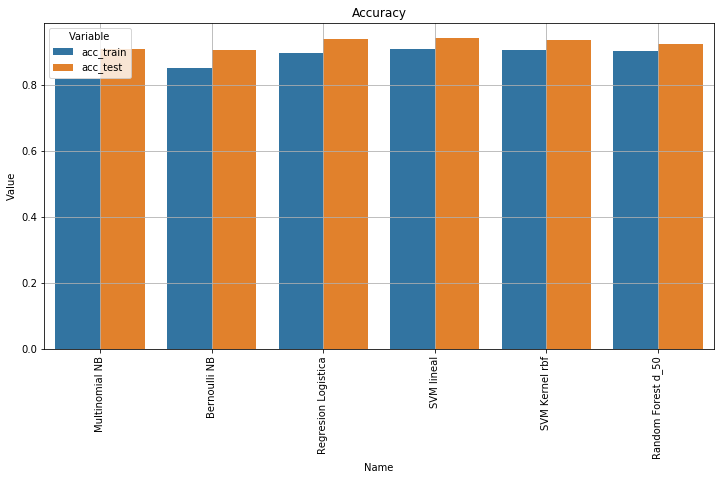

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = results[['acc_train', 'acc_test']].reset_index().melt(id_vars='name').rename(columns=str.title)

# Pintamos el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='Name', y='Value', hue='Variable', data=df_plot)
plt.title("Accuracy")
plt.grid()
plt.xticks(rotation=90)
plt.show()

hr>


# Elección del modelo y exportación en "Pickle"


* El "mejor" modelo (a nivel de accuracy) es el creado por el algoritmo de aprendizaje del ***Support Vector Machine*** utilizando el kernel "***rbf***"; si bien es cierto que sobreajusta bastante a los datos de entrenamiento, obtiene bastantes buenos resultados con los datos de test.


* Dado que este ejercicio es una prueba de concepto no vamos a profundizar mucho en la elección del modelo y seleccionaremos el que mejor accuracy tenga.


##### NOTAS:
##### 1.- Esta elección del modelo se ha realizado con los tweets leidos en el momento de la ejecución. Es posible que si este proceso se ejecuta en otro momento con otros tweets, el mejor modelo puede ser otro.
##### 2.- Para la resolución de este problema se pueden utilizar otros algoritmos de aprendizaje o métodos ensemble que resuelvan problemas de clasificación. También este problema se puede mejorar estudiando los hiperparámetros que se le pasa a los Algoritmos de Aprendizaje.



## 1. Creacción del Modelo con todos los tweets


* Una vez que hemos seleccionado el Algoritmo de Aprendizaje (***Support Vector Machine***) que mejor modelos genera, vamos a crear un modelo utilizando todos los datos (tweets) disponibles en el dataset.


* Pasamos a crear el modelo con todos los datos:

In [19]:
from sklearn.svm import SVC

best_model = SVC(kernel='rbf')
best_model.fit(X_bow, y)

SVC()

* Obtenemos las métricas del modelo con los propios datos de entrenamiento

In [21]:
from sklearn.metrics import classification_report

labels = ['religion', 'age', 'gender', 'ethnicity', 'not_cyberbullying','other_cyberbullying']
print(classification_report(y_true=y, y_pred=best_model.predict(X_bow), labels=labels))

                     precision    recall  f1-score   support

           religion       0.98      0.97      0.97      7784
                age       0.99      0.99      0.99      7717
             gender       0.95      0.91      0.93      7172
          ethnicity       1.00      0.97      0.98      7529
  not_cyberbullying       0.77      0.67      0.72      5340
other_cyberbullying       0.67      0.86      0.75      4821

           accuracy                           0.91     40363
          macro avg       0.89      0.89      0.89     40363
       weighted avg       0.91      0.91      0.91     40363



* Pintamos la matriz de confusión para hacernos una idea de como clasifica el modelo seleccionado.

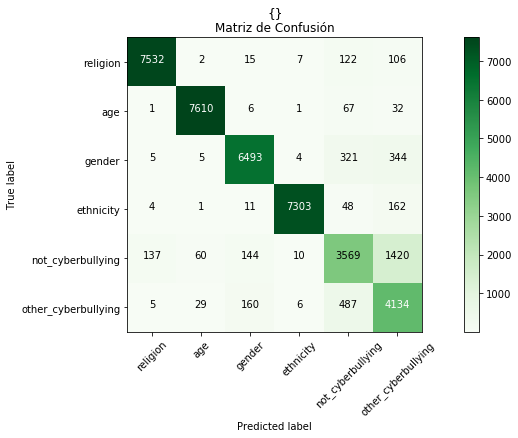

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true=y, y_pred=best_model.predict(X_bow), labels=labels)   

# Pintamos la matriz de confusión
plt.figure(figsize=(12, 6))
plot_confusion_matrix(cm, classes=labels, title='{}\nMatriz de Confusión')

## 2. Exportación del Modelo Pickle


* Ahora vamos a exportar el modelo creado por el Algoritmo de Aprendizaje en formato pickle.


* El modelo creado se ha generado con una determinada ***bolsa de palabras*** que contenia 1000 Palabras en su diccionario. Por tanto tambien tenemos que exportar el modelo generado por el ***CountVectorizer*** para que los nuevos tweets a predecir se ajusten a esa BoW.


* Por tanto tenemos que realizar:
    1. Exportar el ***Modelo*** generado por el Algoritmo de Aprendizaje.
    2. Exportar la ***Bolsa de Palabras*** generado por la clase ***CountVectorizer***.
    
    
* Exportamos el modelo generado por el Algoritmo de Aprendizaje.

In [24]:
import pickle

filename = './models/tweets_normalizados.pickle'
save_model = open(filename,"wb")
pickle.dump(best_model, save_model) # con la función 'dump' guardamos el modelo
save_model.close()


* Exportar la ***Bolsa de Palabras*** generado por la clase ***CountVectorizer***.

In [25]:
filename = './models/tweets_normalizados.pickle'
save_bow = open(filename,"wb")
pickle.dump(vectorizer, save_bow)
save_bow.close()

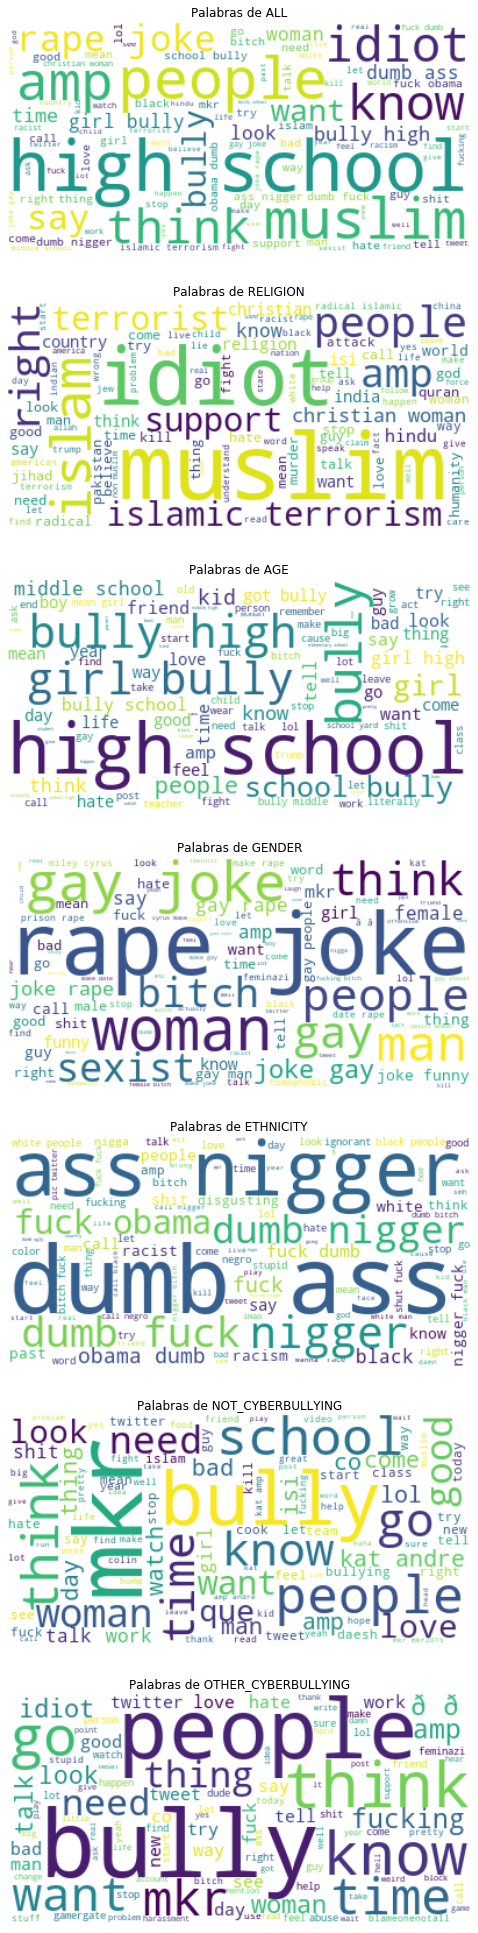

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

 

words_partidos = {
    'all': ' '.join([tweet[0] for tweet in X_norm]),
    'religion': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "religion"]),
    'age': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "age"]),
    'gender': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "gender"]),
    'ethnicity': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "ethnicity"]),
    'not_cyberbullying': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "not_cyberbullying"]),
    'other_cyberbullying': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "other_cyberbullying"])
}

plt.figure(figsize=(40, 35))
pos = 1
for key, words in words_partidos.items():
    plt.subplot(7, 1, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras de {}".format(key.upper()))
    pos += 1
plt.show()

In [2]:
import tweepy
# Claves de cliente y tokens de acceso
CONSUMER_KEY = 'fcCFQpt3lhMzeCgGhznWsb8C5'
CONSUMER_SECRET = 'lljbTkudnEvn0SWn6ZPw5Svam6TzD9q58AhBsgrsqGN9AdqrvF'
ACCESS_TOKEN = '1021745678974902279-7VhCtZkPsqhcaHPq4NFalaShazGbTV'
ACCESS_TOKEN_SECRET = '0xDVjwimkp1WKjjZpMpLuj0V3aRkAeKuvc4DiHkyfvYkZ'

# Proceso de autenticación OAuth
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=False)


In [5]:
account = '@Rubiu5'
num_tweets = 50
tweets = list()
for user_status in api.user_timeline(screen_name=account, count = num_tweets, include_rts=False, tweet_mode="extended"):
        tweets.append(user_status.full_text)

for index, tweet in enumerate(tweets):
    print('\n{} - {}'.format(index, tweet))


0 - bruh https://t.co/KYl64NrKLj

1 - En 30 minutos empezamos el torneo IRL de streamers de #SwitchSportsOpen 🎾

🔴 https://t.co/8ZOxWvmfhQ https://t.co/5DACF6IIcZ

2 - @DjMaRiiO https://t.co/YUlhjtjiMa

3 - Tener amigos para esto 💀 #RubiusX 🍉 @PrimeVideoES https://t.co/JKSbWjMql0

4 - @MrKeroro10 Pago 1.000$ al primero que cierre directo

5 - @Tulio_17_ https://t.co/2V0PlT6wRc

6 - Ojala lo primero que haga Elon Musk al comprar Twitter sea cerrar Twitter

7 - Venía a disculparme públicamente porque sé que lo que he hecho está bastante mal y merecéis que os lo cuente, después de esto probablemente me retire de las redes por un tiempo, así que pues eso perdón por tener este pedazo de culo.

8 - @MAMBIXZ 10/10

9 - @aroiagarcia En serio? xdd

10 - 😩

11 - SOLO FUNCIONA EN MODO OSCURO

12 - @fabyscats Eso no lo sabia 👀

13 - Si escribis GATOS en el Wordle de hoy os saldrá esto 🥲💙 https://t.co/LlvPIsDEa6

14 - ᵗᵉⁿᵍᵒ ᵐᶦᵉᵈᵒ https://t.co/pCkrhJ5bLP

15 - Good game France, you fought well. 

T